## FKA122: H3 | Jonatan Haraldsson & Oscar Stommendal

### Import statements and general functions

In [277]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as K
import pandas as pd
from IPython.display import display, Markdown

# Latex style
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=25.75)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
# Set ticks on both sides
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

# Functions
def read_data(task, ndim, decomp=1, dtau=0.01, walkmen=False, eq=False):
    if task == 1:
        if eq:
            path_eq = f'data/task_{task}/{ndim}D/ET_Nwalk_eq_run.csv'
            data_eq = pd.read_csv(path_eq, delimiter=',', on_bad_lines='skip')
            data_eq = data_eq.apply(pd.to_numeric, errors='coerce')
            data_eq = data_eq.fillna(np.nan)
            data_eq = np.asarray(data_eq)

            return data_eq
        else:
            path_ET = f'data/task_{task}/{ndim}D/ET_Nwalk_non_eq.csv'
            data_ET = pd.read_csv(path_ET, delimiter=',', on_bad_lines='skip')
            data_ET = data_ET.apply(pd.to_numeric, errors='coerce')
            data_ET = data_ET.fillna(np.nan)
            data_ET = np.asarray(data_ET)

            path_walkmen = f'data/task_{task}/{ndim}D/I_was_walkin_in_morse.csv'
            try:
                data_walkmen = pd.read_csv(path_walkmen, delimiter=',', on_bad_lines='skip')
                data_walkmen = data_walkmen.apply(pd.to_numeric, errors='coerce')
                data_walkmen = data_walkmen.fillna(np.nan)
                data_walkmen = data_walkmen[~np.isnan(data_walkmen)]
            except (FileNotFoundError, pd.errors.EmptyDataError, pd.errors.ParserError) as e:
                print(f"Error reading {path_walkmen}: {e}")
                data_walkmen = None
            
            return data_ET, data_walkmen
    
    elif task == 2:
        path_ET = f'data/task_{task}/ET_Nwalk_non_eq_decomp_{decomp}_dtau_{dtau:.6f}.csv'
        data_ET = np.asarray(pd.read_csv(path_ET, delimiter=','))

        path_extrapol = f'data/task_{task}/ET_Nwalks_{decomp}.csv'
        data_extrapol = np.asarray(pd.read_csv(path_extrapol, delimiter=','))

        if walkmen:
            path_walkmen = f'data/task_{task}/I_was_walkin_in_morse_decomp_{decomp}_dtau_{dtau:.6f}.csv'
            data_walkmen = np.asarray(pd.read_csv(path_walkmen, delimiter=',', on_bad_lines='skip'))

            r_1 = np.sqrt(data_walkmen[:, 0]**2 + data_walkmen[:, 1]**2 + data_walkmen[:, 2]**2)
            theta_1 = np.arccos(data_walkmen[:, 2] / r_1)
            phi_1 = np.arctan2(data_walkmen[:, 1], data_walkmen[:, 0])
            r_2 = np.sqrt(data_walkmen[:, 3]**2 + data_walkmen[:, 4]**2 + data_walkmen[:, 5]**2)
            theta_2 = np.arccos(data_walkmen[:, 5] / r_2)
            phi_2 = np.arctan2(data_walkmen[:, 4], data_walkmen[:, 3])

            r12 = np.sqrt((data_walkmen[:, 0] - data_walkmen[:, 3])**2 + (data_walkmen[:, 1] - data_walkmen[:, 4])**2 + (data_walkmen[:, 2] - data_walkmen[:, 5])**2)

            R = [r_1, theta_1, phi_1, r_2, theta_2, phi_2]

            return data_ET, data_extrapol, R, r12
        else:
            return data_ET, data_extrapol

def plot_GSE(ET, tau, dtau, E_0, ndim, task, save=False):
    fig, ax = plt.subplots(1, 2, figsize=(17, 8))

    ax[0].plot(tau, ET, color='tab:red', alpha=0.5)
    ax[0].hlines(E_0, 0, len(ET)*dtau, color='tab:red', label="$E_0$"+f"$\\,={E_0:.3f}$",lw=2.5)
    ax[0].hlines(np.mean(ET), 0, len(ET)*dtau, colors='k', label='$\\langle \\mathcal{E}\\rangle$'+f'$\\, = {np.mean(ET):.3f}$',lw=2.5,ls = 'dashed')
    ax[0].legend()
    ax[0].set_xlabel('Time $\\tau$ [a.u.]')
    ax[0].set_ylabel('Ground-state energy $\\mathcal{E}_i$ [a.u.]')
    # ax[0].set_ylim(-3.2, -2.4)
    ax[0].legend(loc='upper center', ncol=2) 

    ax[1].hist(ET, bins=30, density=True, color='tab:red', alpha=0.5, edgecolor='k')
    std = np.std(ET)
    ax[1].vlines(x=np.mean(ET)-std, ymin=0, ymax=44, color='k', linestyle='dashed', lw=1.5, alpha=0.5)
    ax[1].vlines(x=np.mean(ET)+std, ymin=0, ymax=44, color='k', linestyle='dashed', lw=1.5, alpha=0.5)
    ax[1].vlines(E_0, 0, 44, color='tab:red', label="$E_0$"+f"$\\,={E_0:.3f}$",lw=2.5)
    ax[1].vlines(np.mean(ET), 0, 44, colors='k', label='$\\langle \\mathcal{E}\\rangle$'+f'$\\, = {np.mean(ET):.3f}$',lw=2.5,ls = 'dashed')
    ax[1].set_xlabel('Ground-state energy $\\mathcal{E}$ [a.u.]')
    ax[1].set_ylabel('Probability density')
    ax[1].set_ylim(0, 51)
    ax[1].legend(loc='upper center', ncol=2)

    # ax[1].set_xlim(-3.2, -2.5)
    # ax[0].text(2400, -2.965, '(a)')
    # ax[1].text(-2.912, -11, '(b)')
    plt.tight_layout()

    if save:
        save_fig(plt, 'E_T', task, ndim)

    plt.show()

def plot_walkmen(tau, walk, ndim=1, task=1, save=False):
    fig, ax = plt.subplots(1, 2, figsize=(17, 8))

    ax[0].plot(tau, walk, color='tab:green', alpha=0.5)
    ax[0].hlines(np.mean(walk), 0, np.max(tau), colors='k', label='$\\langle N_{walkers}\\rangle$'+f'$\\,= {np.mean(walk):.0f}$',linestyle='dashed',lw=2.5)
    ax[0].set_xlabel('Time $\\tau$ [a.u.]')
    ax[0].set_ylabel('Number of walkers $N_i$')
    ax[0].set_ylim(925, 1100)
    ax[0].legend(loc='upper left')

    ax[1].hist(walk, bins=30, density=True, color='tab:green', alpha=0.5, edgecolor='k')
    ax[1].set_xlabel('Number of walkers')
    ax[1].set_ylabel('Probability density')
    std = np.std(walk)
    ax[1].vlines(x=np.mean(walk)-std, ymin=0, ymax=0.0235, color='k', linestyle='dashed', lw=1.5, alpha=0.5)
    ax[1].vlines(x=np.mean(walk)+std, ymin=0, ymax=0.0235, color='k', linestyle='dashed', lw=1.5, alpha=0.5)
    ax[1].vlines(np.mean(walk), 0, 0.0235, colors='k', linestyle='dashed', label='$\\langle N_{walkers}\\rangle$'+f'$\\,= {np.mean(walk):.0f}$',lw=2.5)
    ax[1].set_ylim(0, 0.027)
    ax[1].set_xlim(925, 1080)
    ax[1].legend(loc='upper left')
    
    ax[0].text(2400, 886, '(a)')
    ax[1].text(997, -0.006, '(b)')
    plt.tight_layout()

    if save:
        save_fig(plt, 'N_walkers', task, ndim)

    plt.show()

def plot_Rhist(R, decomp, save=False):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharex='col')
    axs[0][0].hist(R[0], bins=50, density=True, color='tab:blue', alpha=0.5, edgecolor='k', label='$r_1$')
    axs[0][1].hist(R[1], bins=50, density=True, color='tab:green', alpha=0.5, edgecolor='k', label='$\\theta_1$')
    axs[0][2].hist(R[2], bins=50, density=True, color='tab:red', alpha=0.5, edgecolor='k', label='$\\phi_1$')

    axs[1][0].hist(R[3], bins=50, density=True, color='tab:blue', alpha=0.5, edgecolor='k', label='$r_2$')
    axs[1][1].hist(R[4], bins=50, density=True, color='tab:green', alpha=0.5, edgecolor='k', label='$\\theta_2$')
    axs[1][2].hist(R[5], bins=50, density=True, color='tab:red', alpha=0.5, edgecolor='k', label='$\\phi_2$')

    for i in range(2):
        axs[i][0].set_xlabel(f'$r_{i+1}$ [a.u.]')
        axs[i][0].text(1.4, 0.8, '\\textbf{{a)}}' if i == 0 else '\\textbf{{d)}}')
        axs[i][1].set_xlabel(f'$\\theta_{i+1}$ [rad]')
        axs[i][1].set_xticks([0, np.pi/2, np.pi])
        axs[i][1].set_xticklabels(['0', '$\\pi / 2$', '$\\pi$'])
        axs[i][1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
        axs[i][1].text(0.3, 0.457, '\\textbf{{b)}}' if i == 0 else '\\textbf{{e)}}')
        axs[i][2].set_xlabel(f'$\\phi_{i+1}$ [rad]')
        axs[i][2].set_xticks([-np.pi, 0, np.pi])
        axs[i][2].set_xticklabels(['$-\\pi$', '0', '$\\pi$'])
        axs[i][2].set_ylim(0, 0.21)
        axs[i][2].text(-2.5, 0.185, '\\textbf{{c)}}' if i == 0 else '\\textbf{{f)}}')

    for ax in axs.flatten():
        ax.grid(alpha=0.5, linestyle='--', lw=1)
        ax.legend()
        ax.set_ylabel('Probability density')

    plt.tight_layout()
    if save:
        save_fig(plt, f'R_hist_{decomp}', 2, 6)

    plt.show()

def save_fig(fig, name, task, ndim):
    fig.savefig(f'figs/task_{task}/{ndim}D/{name}.pdf', bbox_inches='tight')


### Task 1 - Basic 1D DMC Implementation

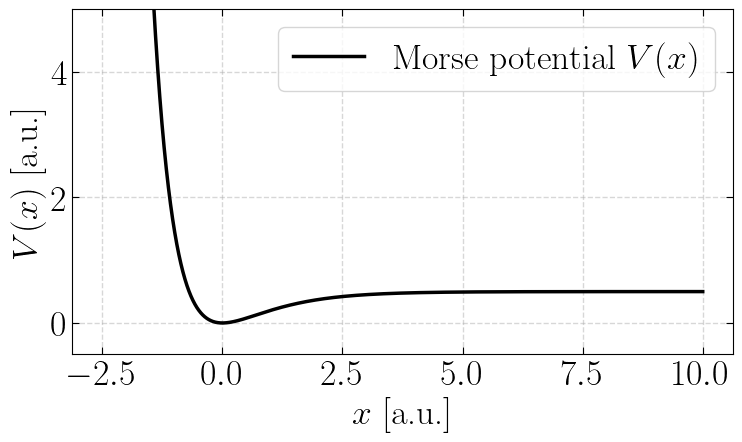

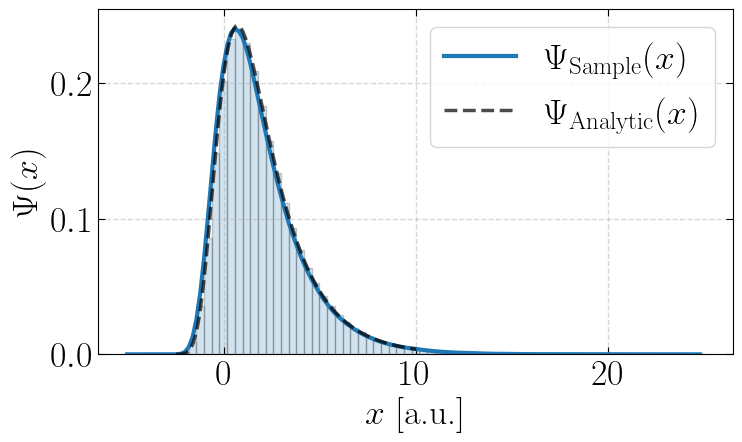

In [273]:

x = np.linspace(-2.5, 10, 10000)
psi = np.exp(-np.exp(-x) - x/2) / np.sqrt(np.pi)
Morse = 0.5 * (1 - np.exp(-x)) ** 2

plt.figure(figsize=(8, 5))
plt.plot(x, Morse, label='Morse potential $V(x)$', color='k', lw=2.5)
plt.xlabel('$x$ [a.u.]')
plt.ylabel('$V(x)$ [a.u.]')
plt.grid(alpha=0.5, linestyle='--', lw=1)
plt.ylim(-.5, 5)
plt.legend()
plt.tight_layout()
# save_fig(plt, 'Morse', 1, 1)

plt.figure(figsize=(8, 5))

_, walker_pos = read_data(1, 1)
bin_size = 150
counts, bins = np.histogram(walker_pos, bins=bin_size)

# Normalize manually
bin_width = bins[1] - bins[0]  # Width of each bin
normalized_counts = counts / (np.sum(counts) * bin_width)

# Plot the manually normalized histogram
plt.hist(walker_pos, bins=int(bin_size/2), density=True, color='tab:blue', alpha=0.2, edgecolor='black', lw=1)
plt.plot(bins[:-1], normalized_counts, color='tab:blue', lw=3, label='$\\Psi_\\mathrm{Sample}(x)$')
plt.plot(x, psi, label='$\\Psi_\\mathrm{Analytic}(x)$', color = 'k', lw=2.5, ls = 'dashed',alpha = 0.7)
plt.xlabel('$x$ [a.u.]')
plt.ylabel('$\\Psi(x)$')
plt.grid(alpha=0.5, linestyle='--', lw=1)

plt.legend()
plt.tight_layout()
# save_fig(plt, 'Wavefunc', 1, 1)

plt.show()


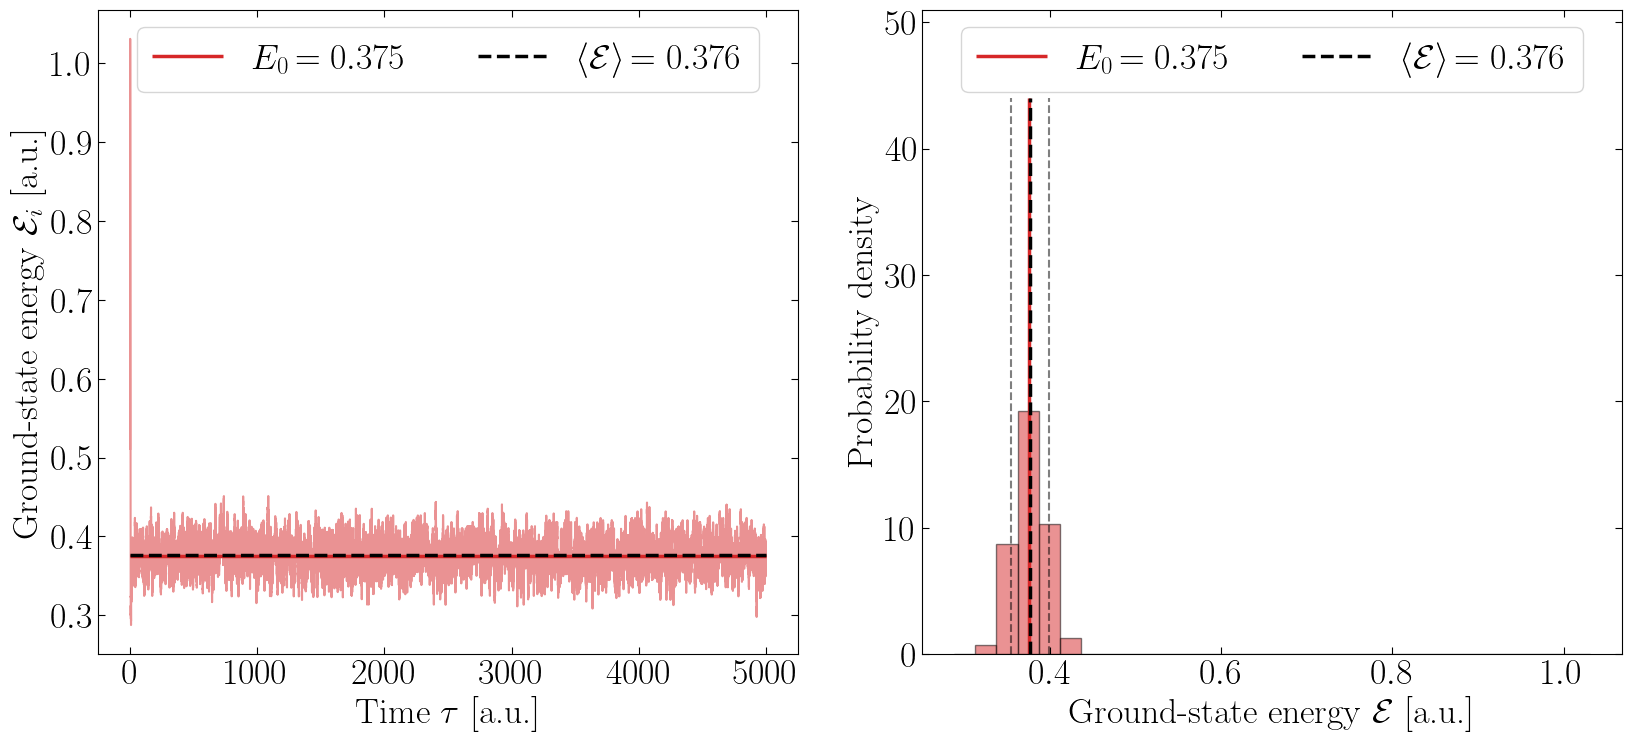

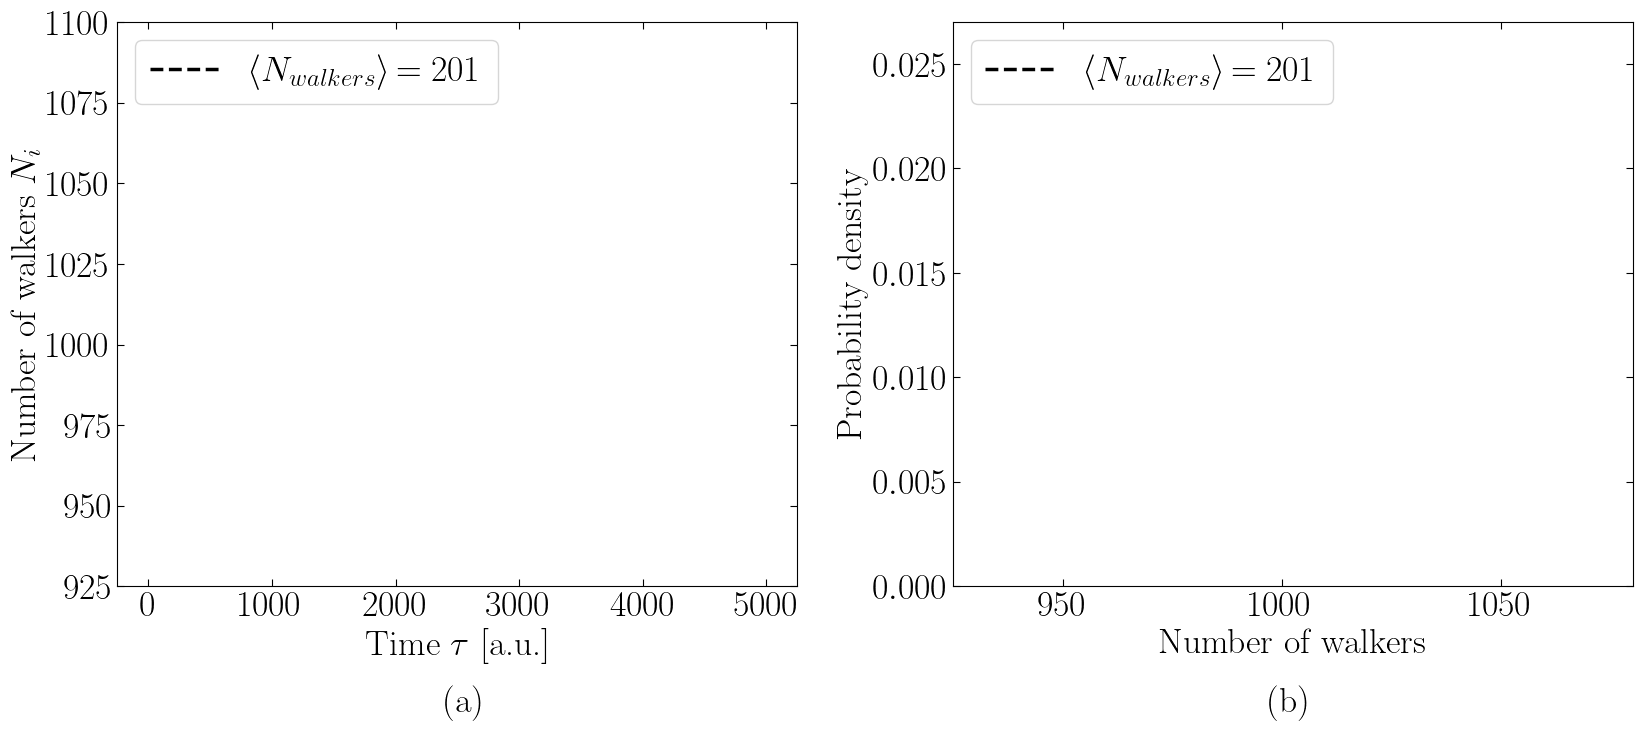

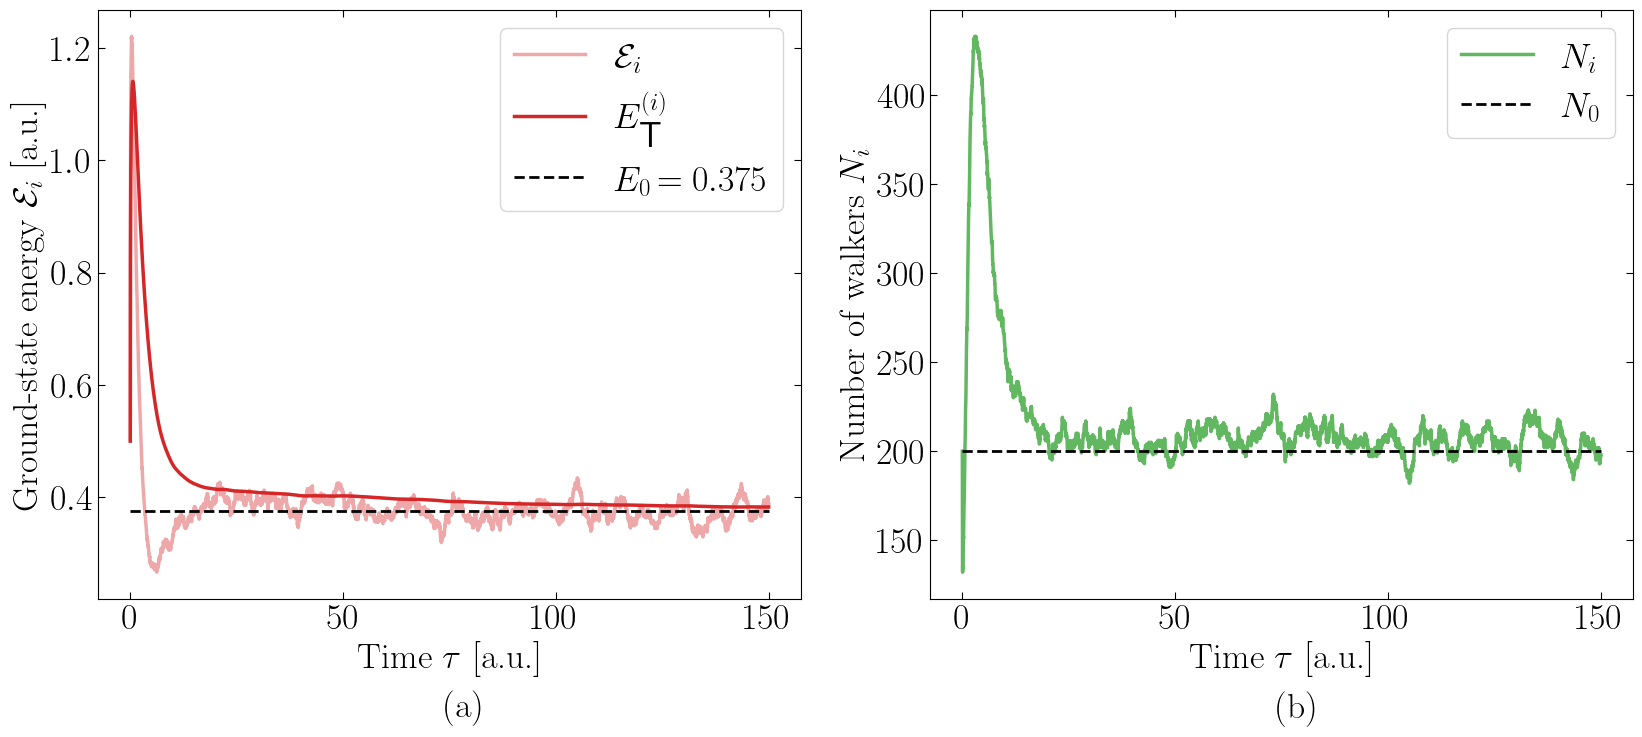

In [ ]:

ET_data, _ = read_data(1, 1)
ET_avg, walk, mort_rate, ET = ET_data.T
tau = np.linspace(0, len(ET) * 0.02, len(ET))
save = False

plot_GSE(ET, tau, 0.02, 3/8, 1, 1, save)

plot_walkmen(tau, walk, save)

# plt.figure()
# #mortality_rate = read_data('ET_Nwalk_non_eq.csv')[:,2]
# plt.plot(tau, mort_rate)
# plt.hlines(100,0,np.max(tau),'b', linestyle = 'dashed')
# plt.hlines(np.mean(mort_rate), 0, np.max(tau),colors='k', label='Mortality rate'+f' = {np.mean(mort_rate):.1f}\\%')
# plt.legend()

ET_avg_eq, walk_eq, mort_rate_eq, ET_eq = read_data(1, 1, eq=True)[:, :].T
ET_avg_eq = np.insert(ET_avg_eq, 0, 0.5)
walk_eq = np.insert(walk_eq, 0, 200)
ET_eq = np.insert(ET_eq, 0, 0.5)
fig, ax = plt.subplots(1, 2, figsize=(17, 8))
ax[0].plot(tau[:len(ET_eq)], ET_eq,color='tab:red', alpha=0.4, lw=2.5, label='$\\mathcal{E}_i$')
ax[0].plot(tau[:len(ET_avg_eq)], ET_avg_eq, color='tab:red', alpha=1, lw=2.5, label='$E_\\textsf{T}^{(i)}$')
ax[1].plot(tau[:len(walk_eq)], walk_eq, color='tab:green', alpha=0.75, lw=2.5, label='$N_i$')
ax[0].set_xlabel('Time $\\tau$ [a.u.]')
ax[0].set_ylabel('Ground-state energy $\\mathcal{E}_i$ [a.u.]')
ax[0].hlines(3/8, 0, len(ET_eq) * 0.02, color='k', label="$E_0$"+f"$\\,={3/8:.3f}$", lw=2, ls = 'dashed')
ax[1].hlines(200, 0, len(walk_eq) * 0.02, color='k', label="$N_0$", lw=2, ls='dashed')

ax[1].set_xlabel('Time $\\tau$ [a.u.]')
ax[1].set_ylabel('Number of walkers $N_i$')

ax[0].text(74, 0.01, '(a)')
ax[1].text(74, 50, '(b)')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
plt.tight_layout()
# save_fig(plt, 'ET_Nwalk_eq', 1)

plt.show()


### Task 2 - DMC Applied to the Helium Atom

Error reading data/task_1/6D/I_was_walkin_in_morse.csv: [Errno 2] No such file or directory: 'data/task_1/6D/I_was_walkin_in_morse.csv'


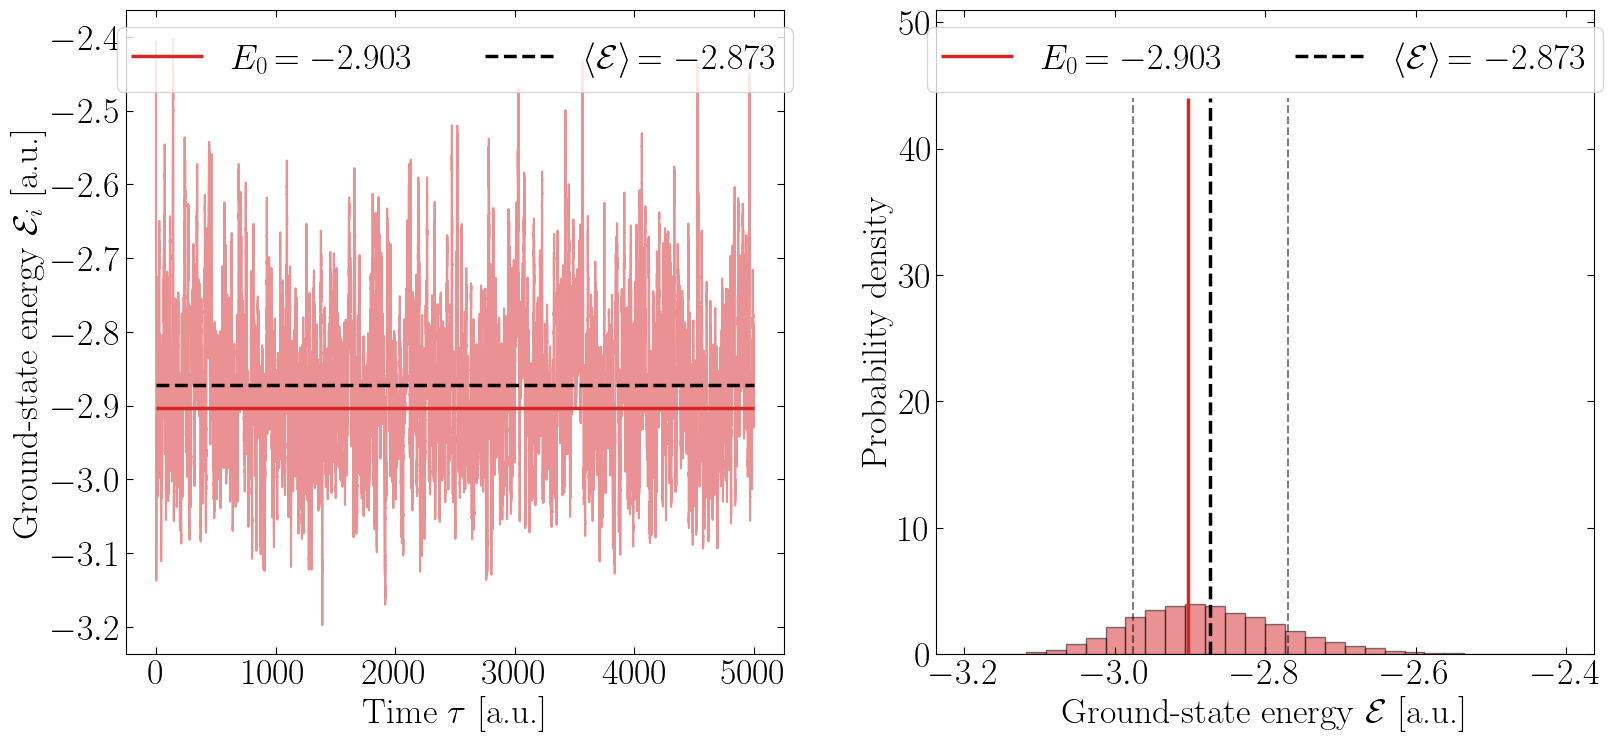

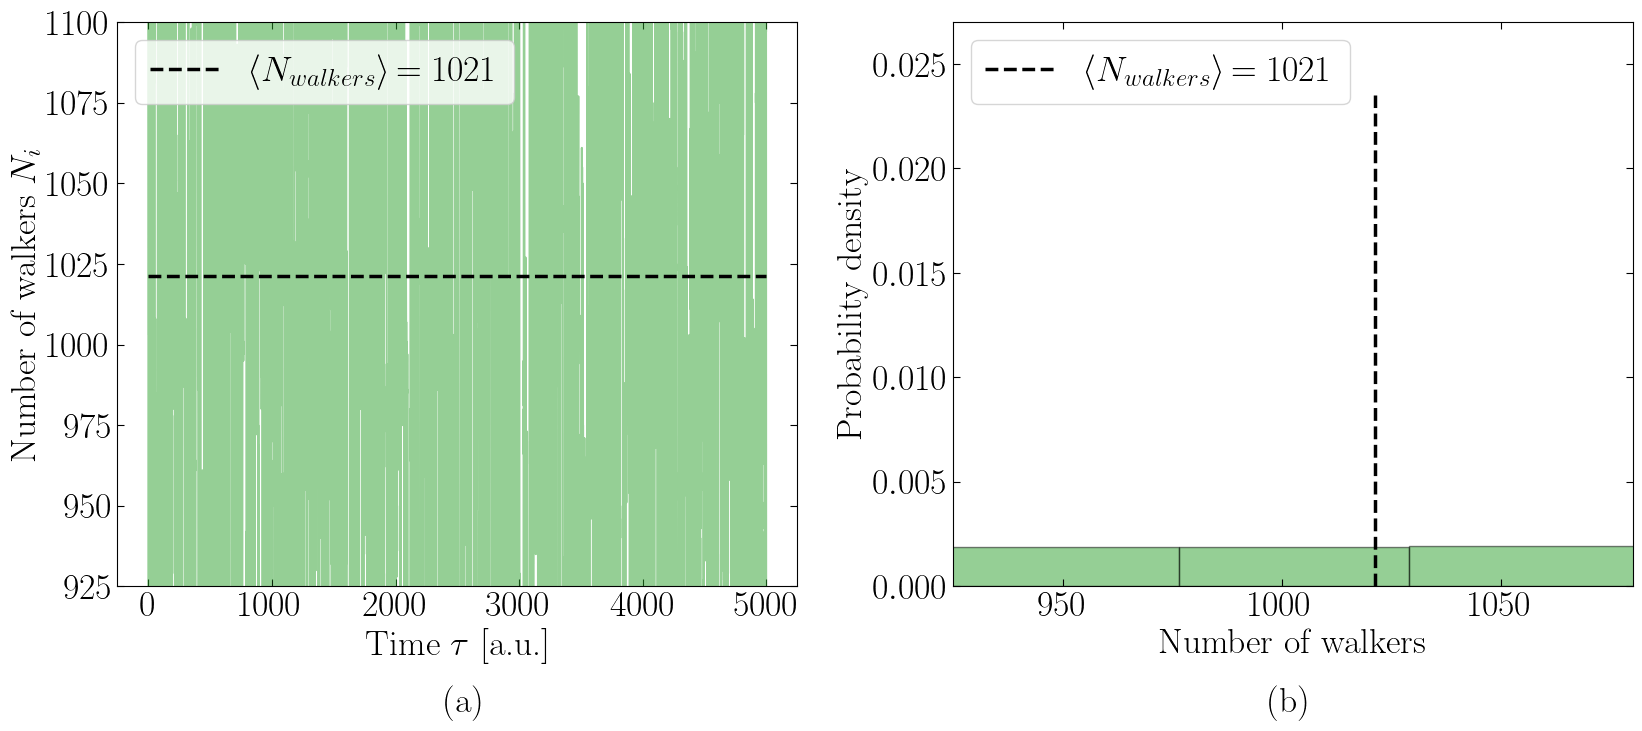

In [280]:

data_ET, _ = read_data(1, 6)
ET_avg, walk, mort_rate, ET = data_ET.T
dtau = 0.01
tau = np.linspace(0, len(ET) * dtau, len(ET))
E_0_He = -2.903
save = False

plot_GSE(ET, tau, dtau, E_0_He, ndim=6, task=1, save=save)
plot_walkmen(tau, walk, ndim=6, task=1, save=save)


### Task 3 - DMC with Importance Sampling

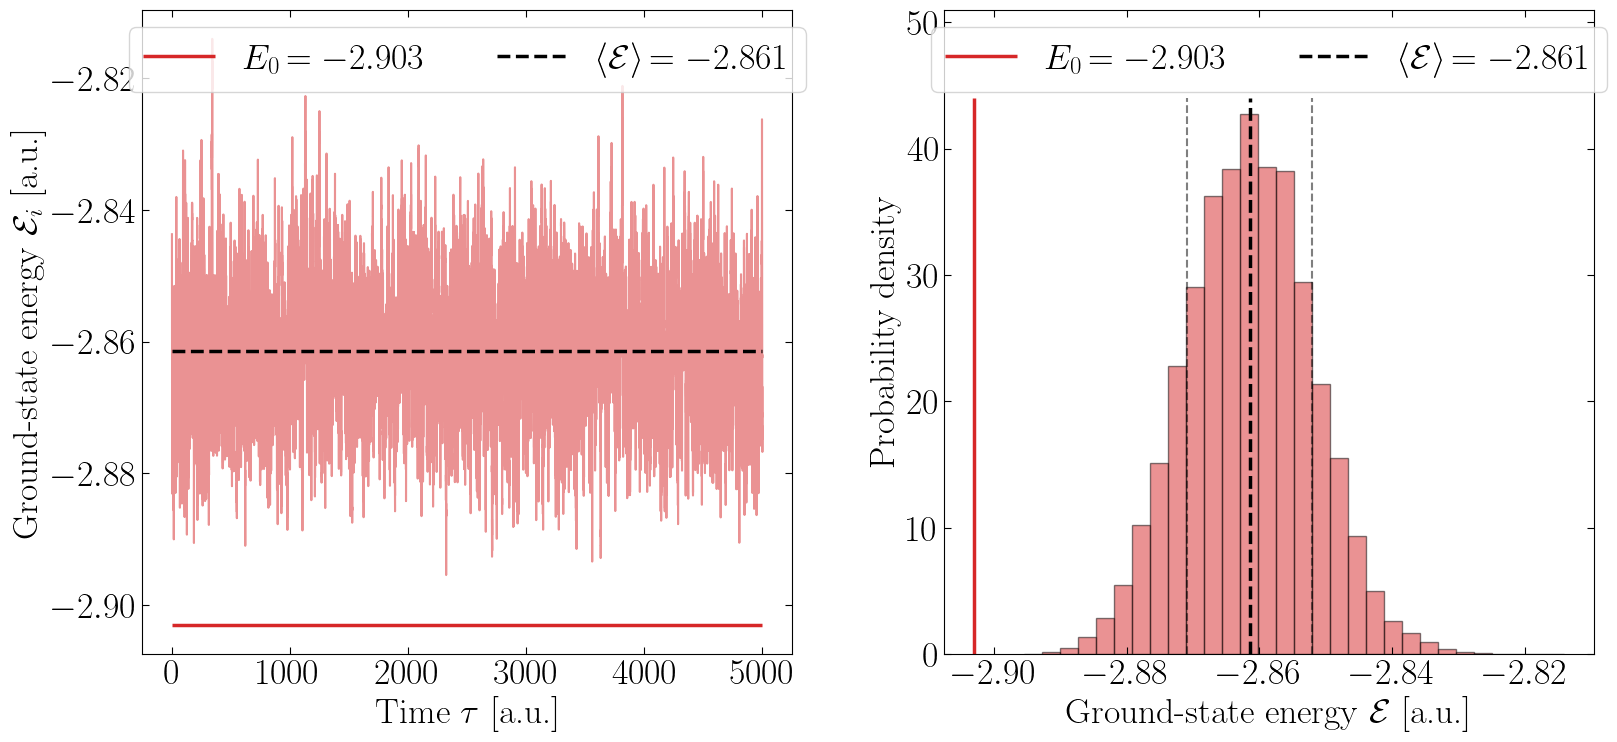

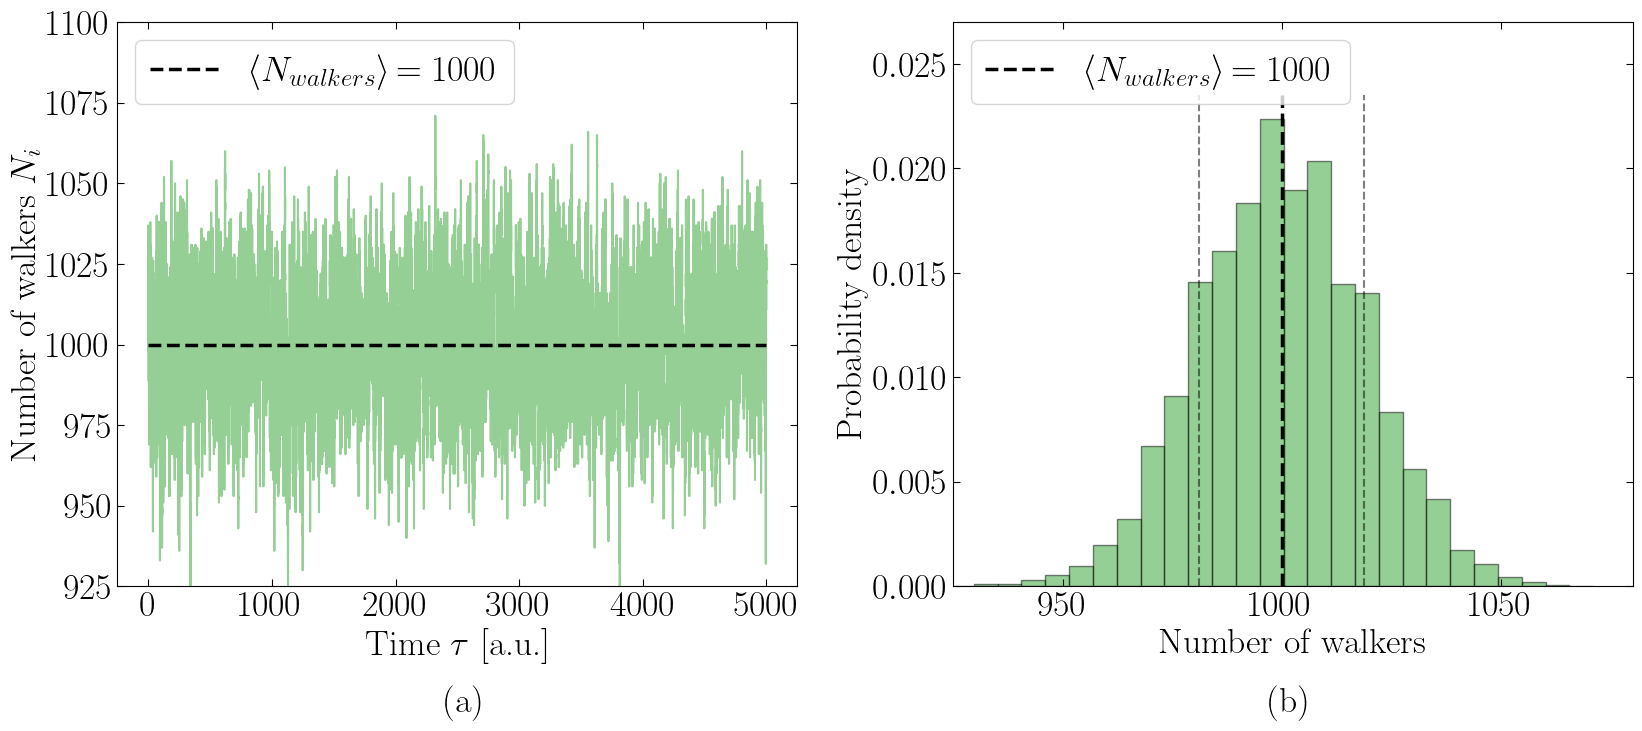

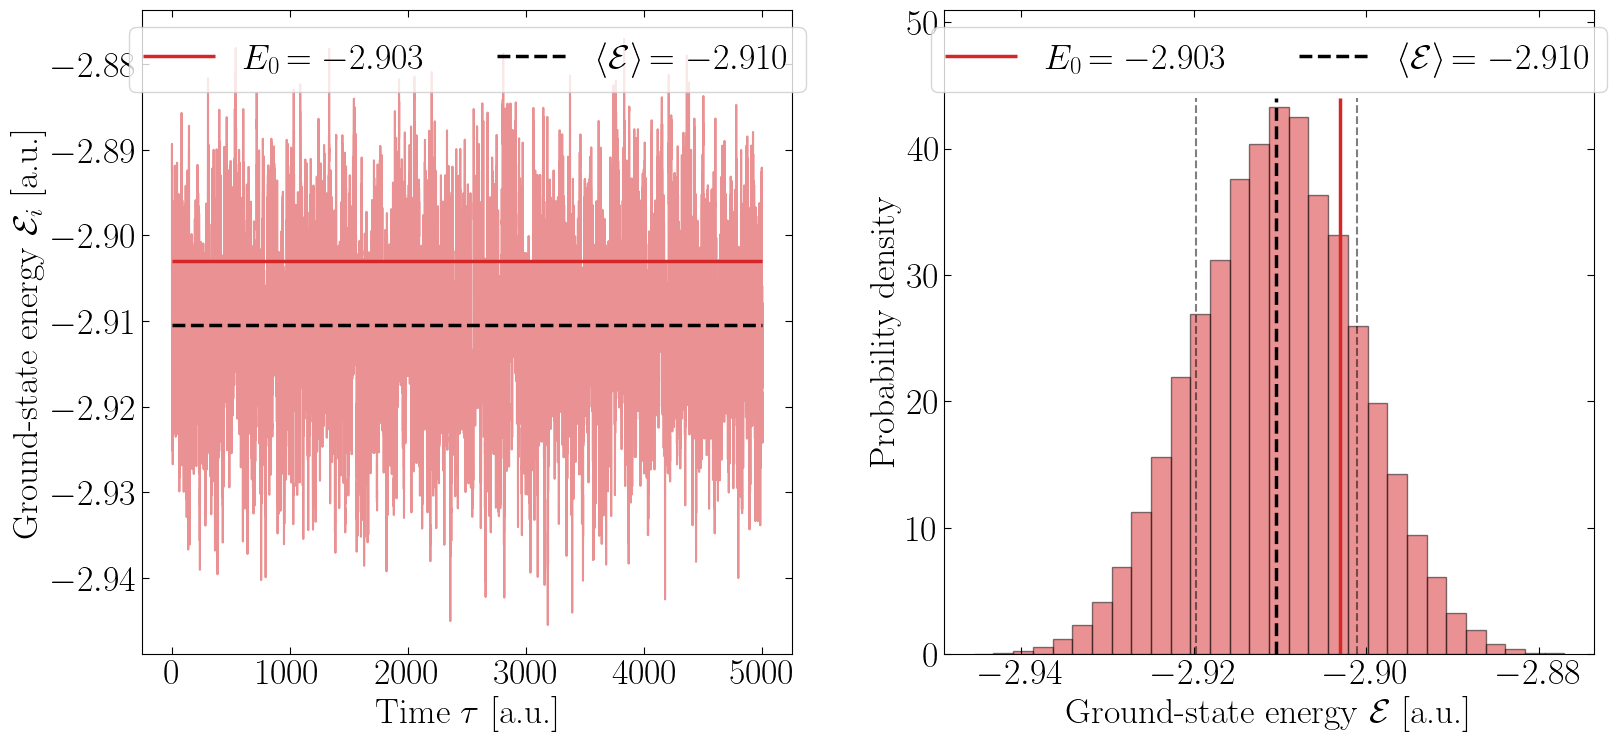

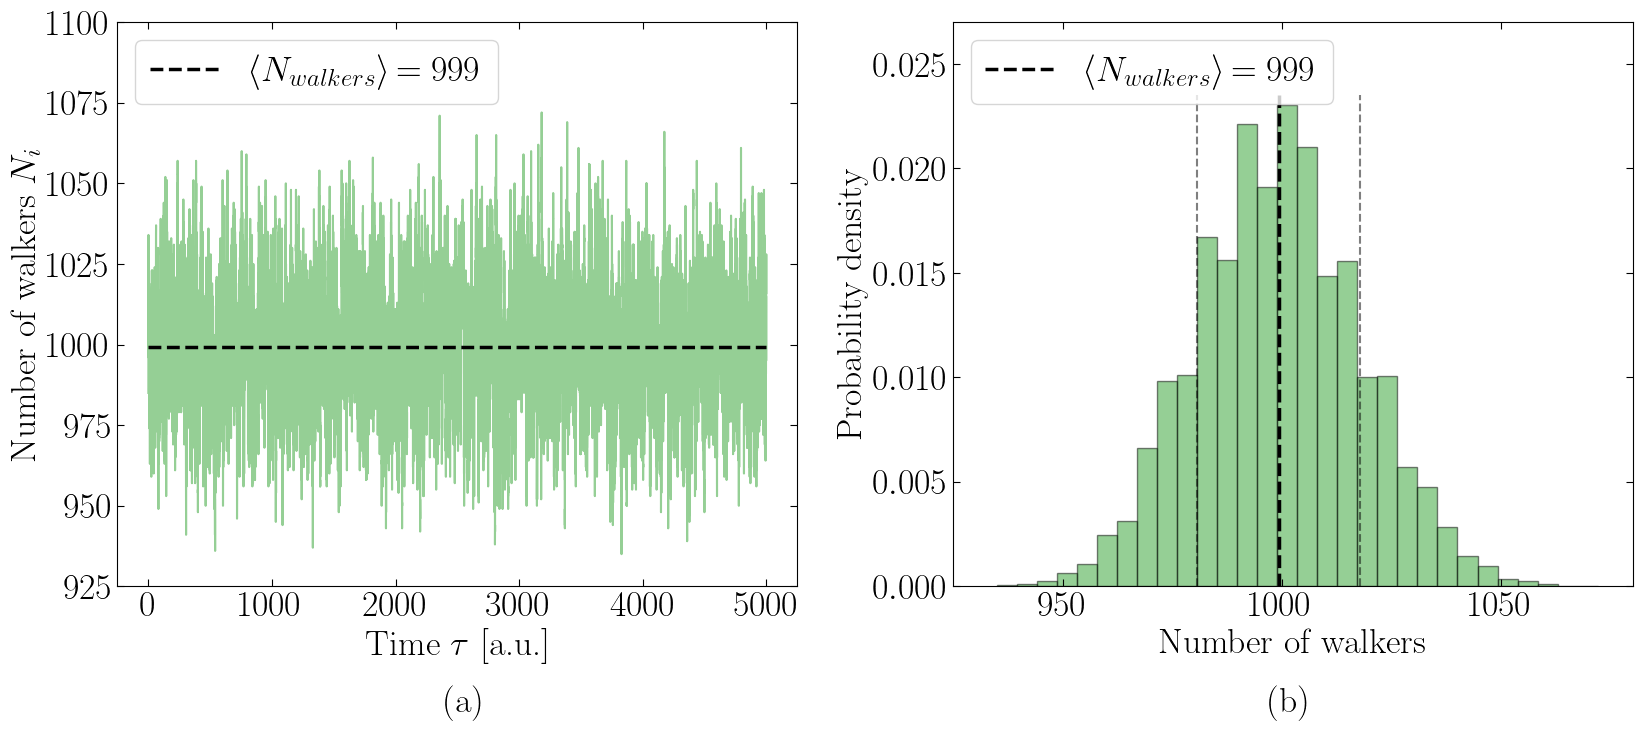

In [281]:

dtau = 0.1
E_0_He = -2.903

data_ET_1, data_extrapol_1 = read_data(2, 1, decomp=1, dtau=dtau)
ET_avg_1, walk_1, mort_rate_1, ET_1 = data_ET_1.T

data_ET_2, data_extrapol_2 = read_data(2, 1, decomp=2, dtau=dtau)
ET_avg_2, walk_2, mort_rate_2, ET_2 = data_ET_2.T

tau = np.linspace(0, len(ET_1) * dtau, len(ET_1))
plot_GSE(ET_1, tau, dtau, E_0_He, ndim=6, task=2, save=False)
plot_walkmen(tau, walk_1, ndim=6, task=2, save=False)

plot_GSE(ET_2, tau, dtau, E_0_He, ndim=6, task=2, save=False)
plot_walkmen(tau, walk_2, ndim=6, task=2, save=False)

Best estimation of E_0 for decomp 1: -2.926
Best estimation of E_0 for decomp 2: -2.933


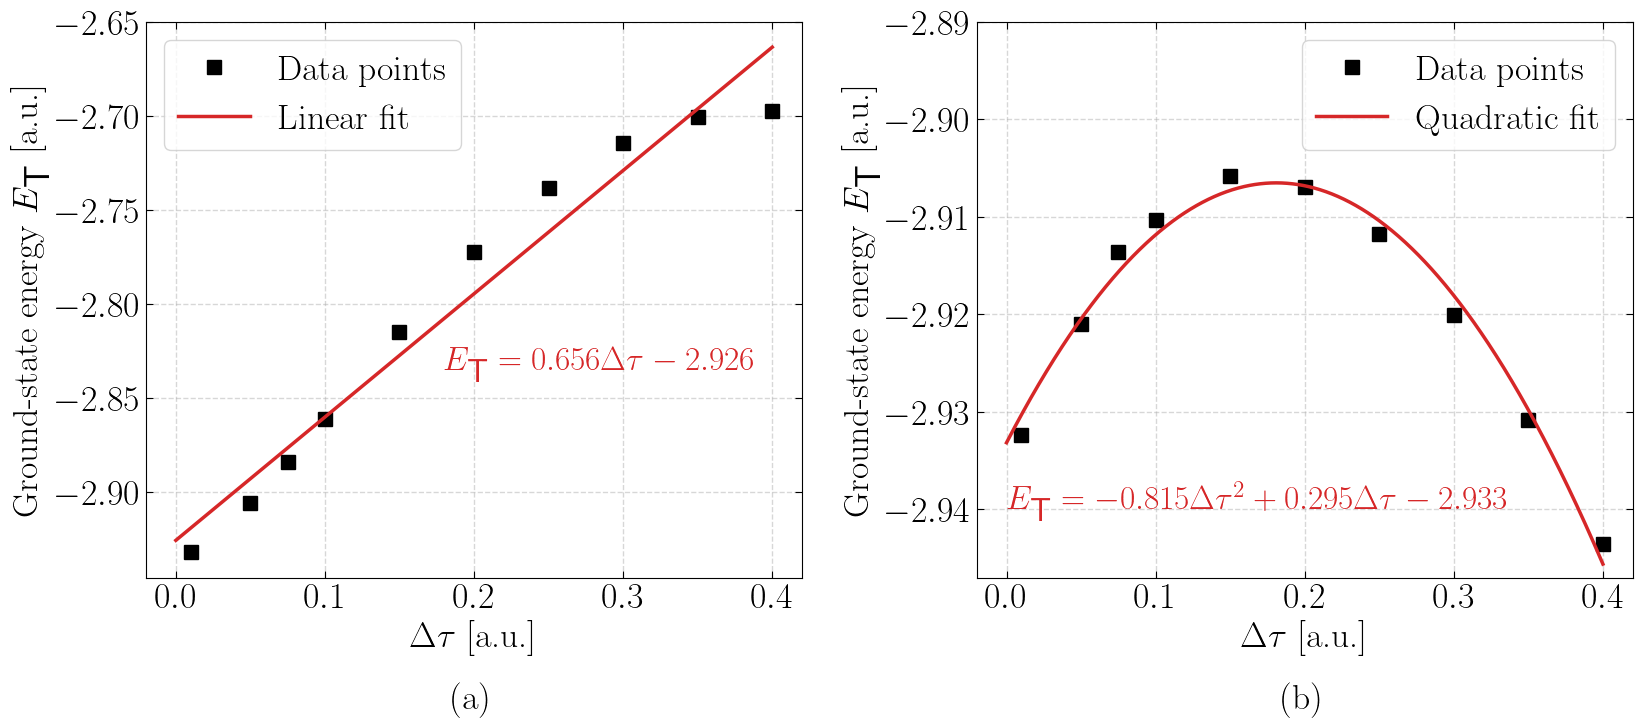

In [282]:

# Fit the extrapolated data
fit_1 = np.polyfit(data_extrapol_1[:,0], data_extrapol_1[:,1], 1)
fit_2 = np.polyfit(data_extrapol_2[:,0], data_extrapol_2[:,1], 2)
dtaus = np.linspace(0, 0.4, 1000)

print(f"Best estimation of E_0 for decomp 1: {fit_1[1]:.3f}")
print(f"Best estimation of E_0 for decomp 2: {fit_2[2]:.3f}")

# Plot the extrapolated data
fig, axs = plt.subplots(1, 2, figsize=(17, 8))
axs[0].plot(data_extrapol_1[:,0], data_extrapol_1[:,1], 's', label='Data points', color='k', markersize=10)
axs[0].plot(dtaus, np.polyval(fit_1, dtaus), label='Linear fit', color='tab:red', lw=2.5)

axs[1].plot(data_extrapol_2[:,0], data_extrapol_2[:,1], 's', label='Data points', color='k', markersize=10)
axs[1].plot(dtaus, np.polyval(fit_2, dtaus), label='Quadratic fit', color='tab:red', lw=2.5)

for ax in axs:
    ax.set_xlabel('$\\Delta\\tau$ [a.u.]')
    ax.set_ylabel('Ground-state energy $E_\\textsf{T}$ [a.u.]')
    ax.legend()
    ax.grid(alpha=0.5, linestyle='--', lw=1)
axs[1].legend(loc='upper right')
axs[1].set_ylim(-2.947, -2.89)

axs[0].text(0.185, -3.015, '(a)')
axs[1].text(0.185, -2.9605, '(b)')

axs[0].text(0.18, -2.835, f'$E_\\textsf{{T}} = {fit_1[0]:.3f}\\Delta \\tau {fit_1[1]:.3f}$', color='tab:red', fontsize=24)
axs[1].text(0., -2.94, f'$E_\\textsf{{T}} = {fit_2[0]:.3f}\\Delta \\tau^2 + {fit_2[1]:.3f}\\Delta \\tau {fit_2[2]:.3f}$', color='tab:red', fontsize=24)

plt.tight_layout()
# save_fig(plt, 'extrapolation', 2, 6)
plt.show()


In [283]:

_, _, R_1, r12_1 = read_data(2, 6, decomp=1, dtau=dtau, walkmen=True)
_, _, R_2, r12_2 = read_data(2, 6, decomp=2, dtau=dtau, walkmen=True)


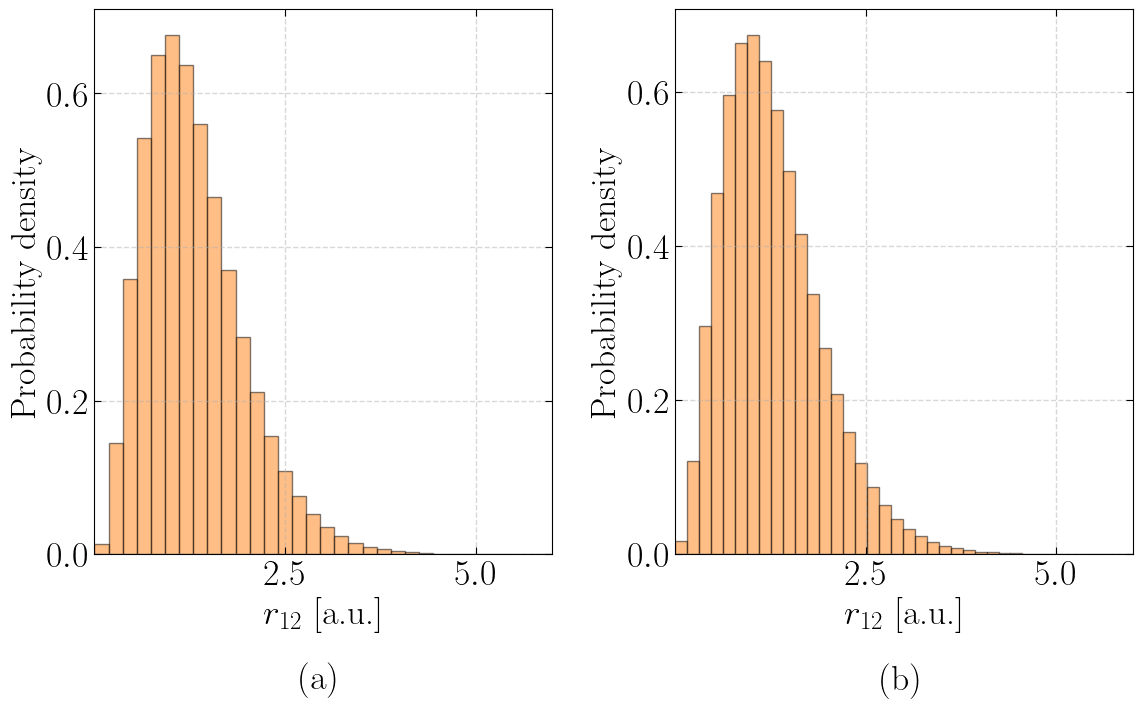

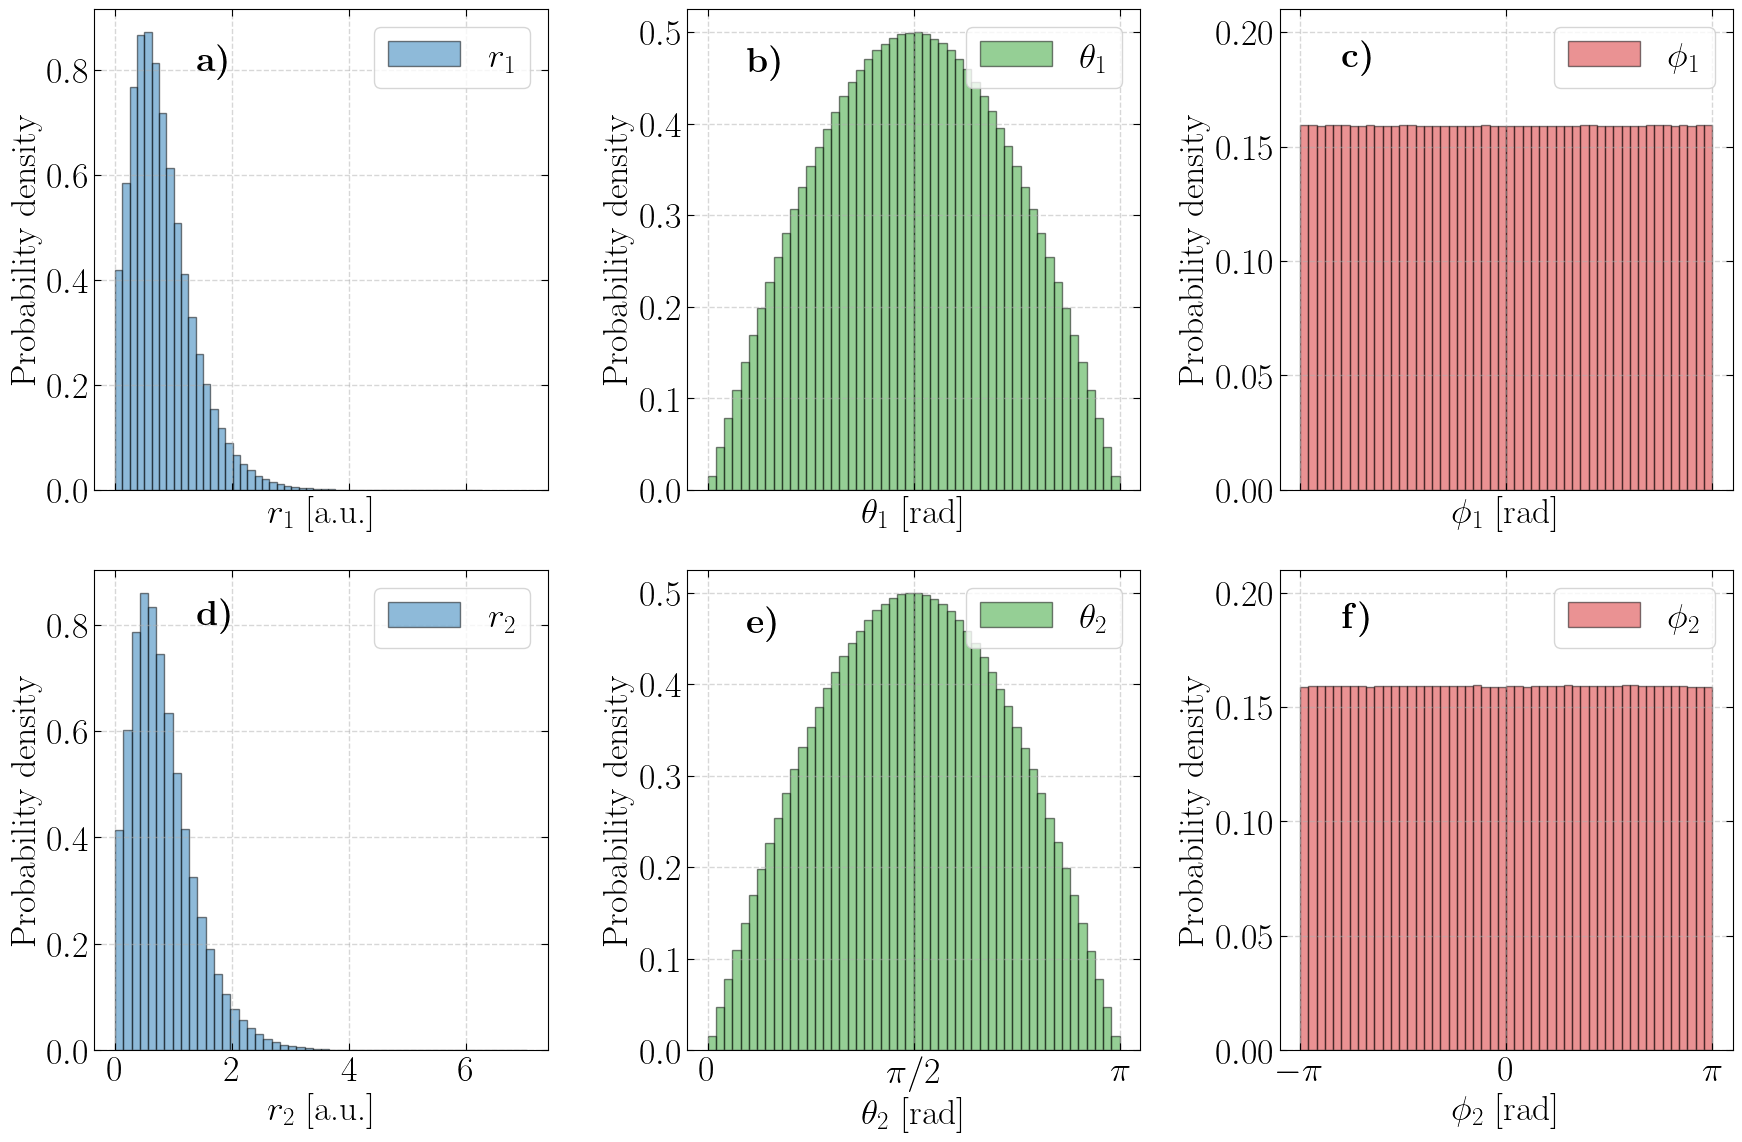

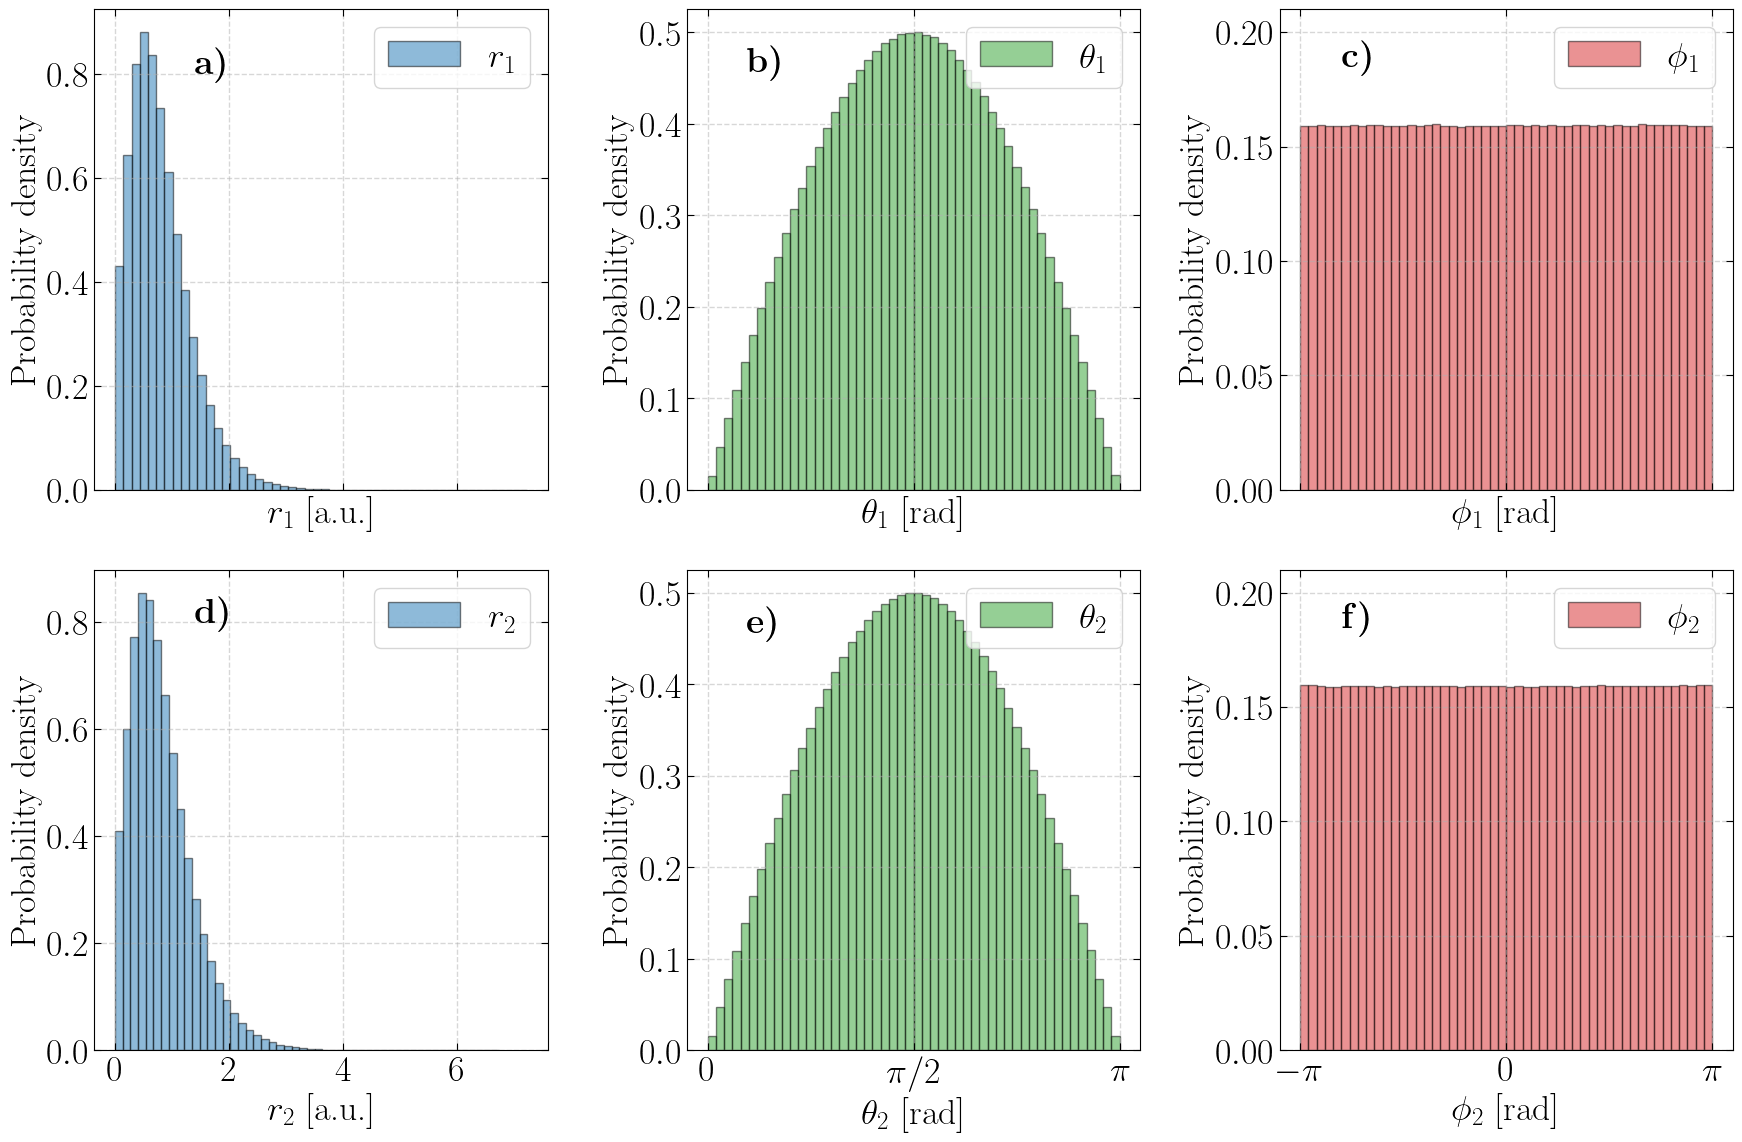

In [284]:

fig, axs = plt.subplots(1, 2, figsize=(12, 7))
axs[0].hist(r12_1, bins=50, density=True, color='tab:orange', alpha=0.5, edgecolor='k')
axs[1].hist(r12_2, bins=50, density=True, color='tab:orange', alpha=0.5, edgecolor='k')

for ax in axs:
    ax.set_xticks([2.5, 5])
    ax.set_xlim(0, 6)
    ax.set_xlabel('$r_{12}$ [a.u.]')
    ax.set_ylabel('Probability density')
    ax.grid(alpha=0.5, linestyle='--', lw=1)

plt.tight_layout()
axs[0].text(2.7, -0.175, '(a)')
axs[1].text(2.7, -0.175, '(b)')
# save_fig(plt, 'r12', 2, 6)

plot_Rhist(R_1, 1, save=False)
plot_Rhist(R_2, 2, save=False)
